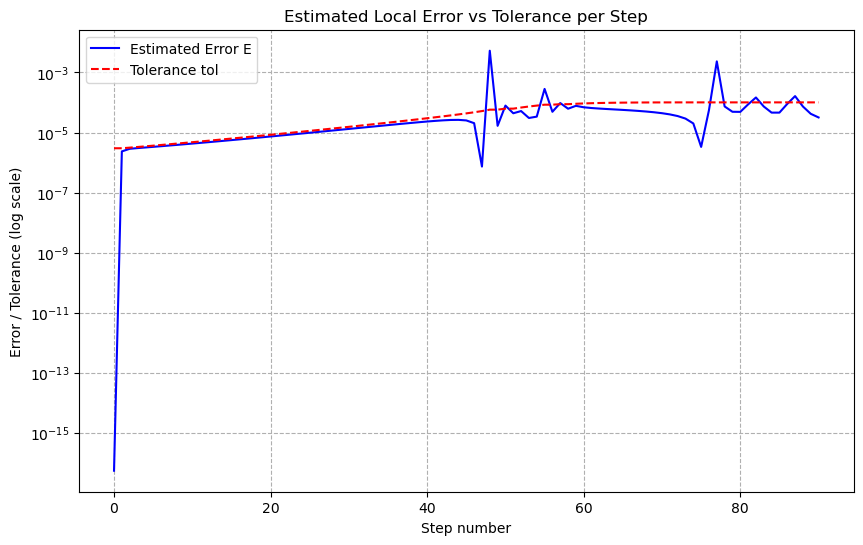

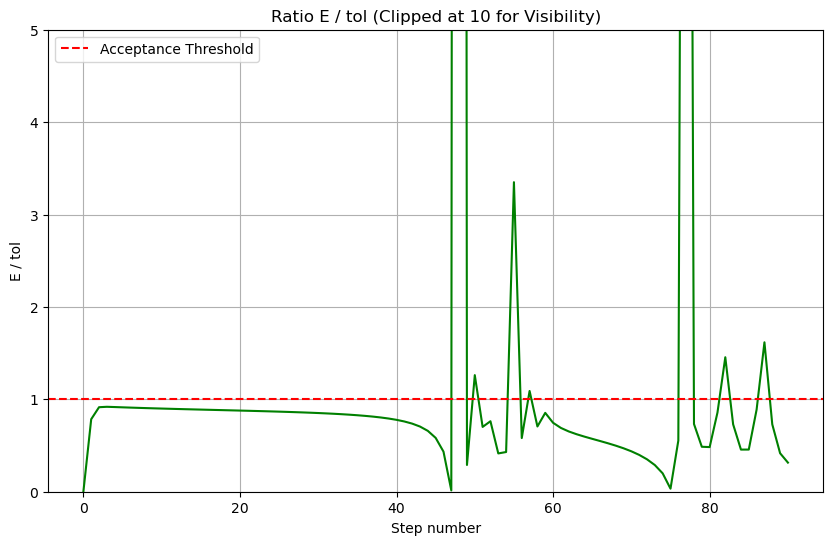

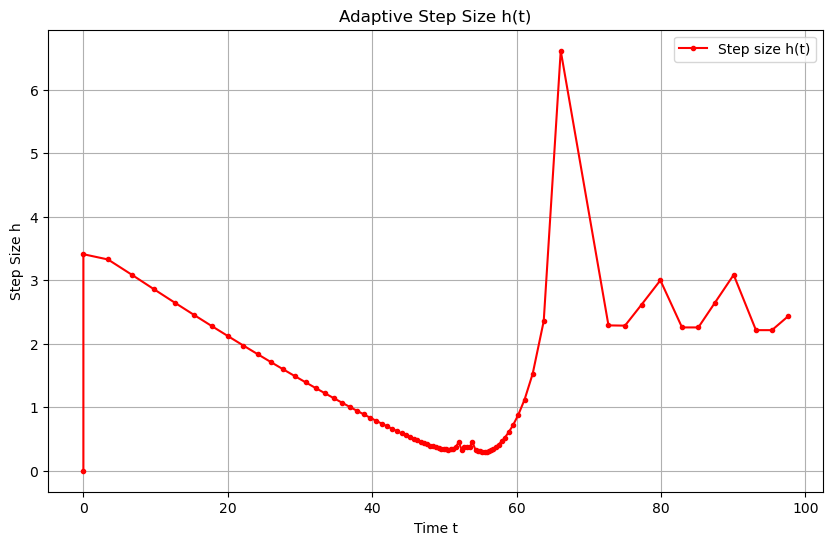

Total number of steps taken: 84


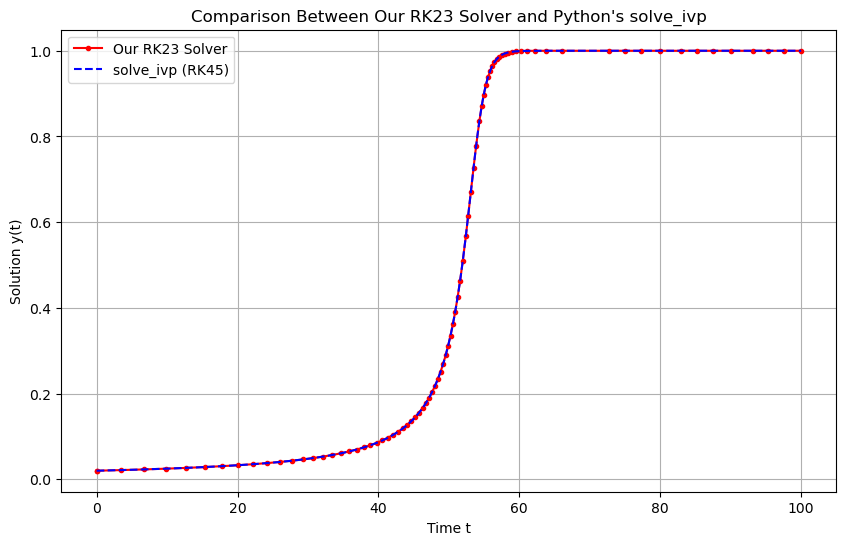

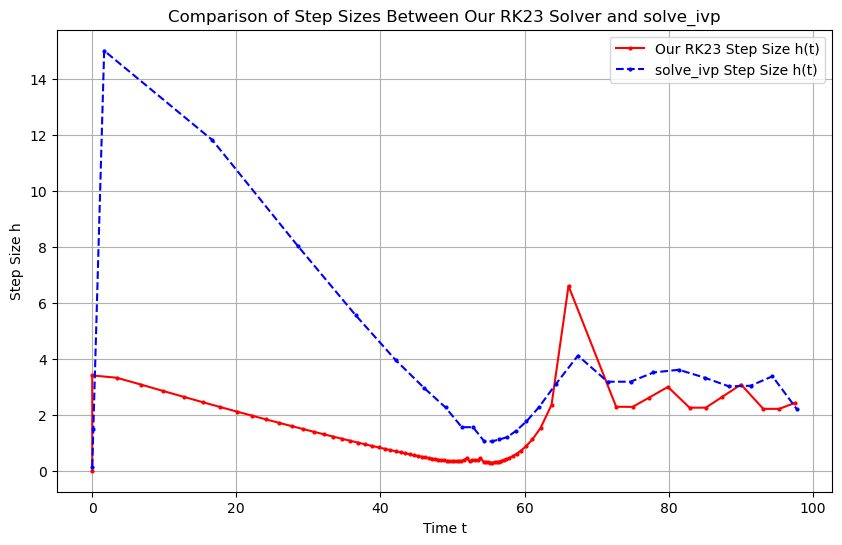

Total accepted steps (RK23 solver): 84
Total accepted steps (solve_ivp): 29


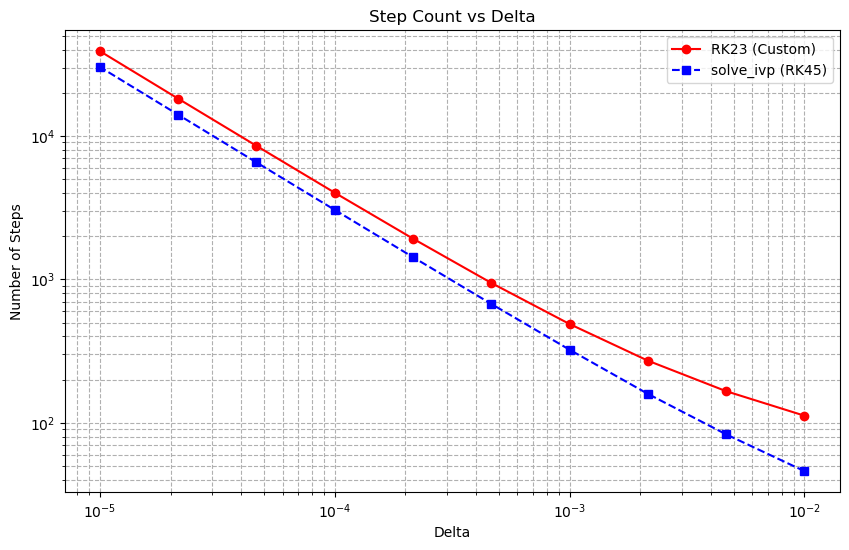

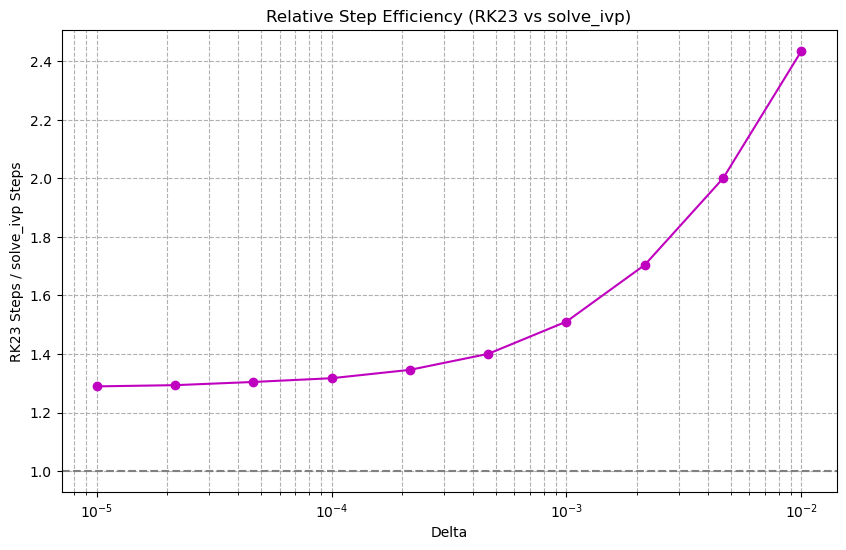

In [2]:


import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def flame_rhs(t, y, parm=None):
    return y**2 - y**3

def rksolver(func, t0, t1, y0, aeps=1e-6, reps=1e-4, parm=None, h_init=1e-3, h_min=1e-8):
    t = t0
    y = np.array(y0, dtype=float)
    h = h_init

    t_list = [t]
    y_list = [y.copy()]
    h_list = []
    error_list = []
    tol_list = []

    b = np.array([1/6, 2/3, 1/6])
    tilde_b = np.array([1/4, 1/2, 1/4])
    d = b - tilde_b

    while t < t1:
        if t + h > t1:
            h = t1 - t

        xi_1 = y
        f1 = func(t, xi_1, parm)

        xi_2 = y + (h / 2) * f1
        f2 = func(t + 0.5 * h, xi_2, parm)

        xi_3 = y + h * (-f1 + 2 * f2)
        f3 = func(t + h, xi_3, parm)

        y_high = y + h * (b[0] * f1 + b[1] * f2 + b[2] * f3)

        E_vec = h * (d[0] * f1 + d[1] * f2 + d[2] * f3)
        E = np.linalg.norm(E_vec, ord=2) if np.ndim(E_vec) > 0 else abs(E_vec)
        tol = reps * np.linalg.norm(y, ord=2) + aeps if np.ndim(y) > 0 else reps * abs(y) + aeps

        h_list.append(h)
        error_list.append(E)
        tol_list.append(tol)

        if E <= tol:
            t += h
            y = y_high
            t_list.append(t)
            y_list.append(y.copy())

        safety = 0.9
        h = max(h_min, h * safety * (tol / E)**(1/3) if E > 0 else h * 2)

    return np.array(t_list), np.array(y_list), np.array(h_list), np.array(error_list), np.array(tol_list)

# Problem setup
delta = 0.02
t0 = 0
t1 = 2 / delta
y0 = delta

# Run custom solver
t_list, y_list, h_steps, error_list, tol_list = rksolver(flame_rhs, t0, t1, y0)

# Comparison with solve_ivp
sol = solve_ivp(
    flame_rhs,
    [t0, t1],
    [y0],
    args=(None,),
    rtol=1e-4,
    atol=1e-6,
    dense_output=True
)

# Plotting
steps = np.arange(len(error_list))
h_our = np.diff(t_list)
h_ivp = np.diff(sol.t)
t_fine = np.linspace(t0, t1, 1000)
y_fine = sol.sol(t_fine)[0]

## Step 2: Visualize Local Error and Tolerance

# Plot estimated local error E(t)
plt.figure(figsize=(10,6))
plt.plot(steps, error_list, 'b-', label='Estimated Error E')
plt.plot(steps, tol_list, 'r--', label='Tolerance tol')
plt.yscale('log')
plt.xlabel('Step number')
plt.ylabel('Error / Tolerance (log scale)')
plt.title('Estimated Local Error vs Tolerance per Step')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()

# Plot E(t)/tol(t) to check if <= 1
plt.figure(figsize=(10,6))
plt.plot(steps, np.array(error_list)/np.array(tol_list), 'g-')
plt.axhline(y=1, color='r', linestyle='--', label='Acceptance Threshold')
plt.ylim(0, 5)  # 👈 This clips the y-axis to focus on relevant range
plt.xlabel('Step number')
plt.ylabel('E / tol')
plt.title('Ratio E / tol (Clipped at 10 for Visibility)')
plt.grid(True)
plt.legend()
plt.show()


## Step 3: Plot Adaptive Step Sizes

# Plot step sizes h(t)
plt.figure(figsize=(10,6))
plt.plot(t_list[:-1], h_our, 'r.-', label='Step size h(t)')
plt.xlabel('Time t')
plt.ylabel('Step Size h')
plt.title('Adaptive Step Size h(t)')
plt.grid(True)
plt.legend()
plt.show()

print(f"Total number of steps taken: {len(t_list)-1}")

## Step 4: Compare with SciPy's `solve_ivp`

# Plot solution comparison
plt.figure(figsize=(10,6))
plt.plot(t_list, y_list, 'ro-', markersize=3, label='Our RK23 Solver')
plt.plot(t_fine, y_fine, 'b--', label='solve_ivp (RK45)')
plt.xlabel('Time t')
plt.ylabel('Solution y(t)')
plt.title("Comparison Between Our RK23 Solver and Python's solve_ivp")
plt.legend()
plt.grid(True)
plt.show()

# Compare step sizes
plt.figure(figsize=(10,6))
plt.plot(t_list[:-1], h_our, 'r.-', markersize=4, label='Our RK23 Step Size h(t)')
plt.plot(sol.t[:-1], h_ivp, 'b.--', markersize=4, label='solve_ivp Step Size h(t)')
plt.xlabel('Time t')
plt.ylabel('Step Size h')
plt.title('Comparison of Step Sizes Between Our RK23 Solver and solve_ivp')
plt.legend()
plt.grid(True)
plt.show()

# Count accepted steps from custom solver
steps_rk23 = len(t_list) - 1  # exclude initial time

# Count steps from solve_ivp
steps_ivp = len(sol.t) - 1

print(f"Total accepted steps (RK23 solver): {steps_rk23}")
print(f"Total accepted steps (solve_ivp): {steps_ivp}")



deltas = np.logspace( np.log10(0.01), np.log10(0.00001), num=10)

rk23_steps = []
ivp_steps = []

for delta in deltas:
    t0 = 0
    t1 = 2 / delta
    y0 = delta

    # Run your solver
    t_list, y_list, *_ = rksolver(flame_rhs, t0, t1, y0, reps=1e-4, aeps=1e-6)
    rk23_steps.append(len(t_list) - 1)

    # Run SciPy's solve_ivp
    sol = solve_ivp(flame_rhs, [t0, t1], [y0], args=(None,), rtol=1e-4, atol=1e-6)
    ivp_steps.append(len(sol.t) - 1)

# Convert to arrays
rk23_steps = np.array(rk23_steps)
ivp_steps = np.array(ivp_steps)

# Plotting the comparison
plt.figure(figsize=(10,6))
plt.plot(deltas, rk23_steps, 'ro-', label='RK23 (Custom)')
plt.plot(deltas, ivp_steps, 'bs--', label='solve_ivp (RK45)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Delta')
plt.ylabel('Number of Steps')
plt.title('Step Count vs Delta')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.show()

# Plot ratio of steps: RK23 / solve_ivp
step_ratio = rk23_steps / ivp_steps

plt.figure(figsize=(10,6))
plt.plot(deltas, step_ratio, 'm-o')
plt.axhline(y=1, color='gray', linestyle='--')
plt.xscale('log')
plt.xlabel('Delta')
plt.ylabel('RK23 Steps / solve_ivp Steps')
plt.title('Relative Step Efficiency (RK23 vs solve_ivp)')
plt.grid(True, which='both', linestyle='--')
plt.show()
